In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch.autograd import Variable
import math
import torch.nn
def accuracy(y, y_hat):
    a=(y==y_hat)
    return a.astype(np.float).mean()

## Load and flatten the image 

In [141]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
labels=labels.astype(int)
labels[labels!=0]=-1
labels[labels==0]=1
labels[labels==-1]=0


In [142]:
shape_images_flat=(images.shape[0],images.shape[1]*images.shape[2])
images_flat=np.ndarray(shape=shape_images_flat)
for index in range(len(images)):
    images_flat[index]=images[index].flat
images_flat=(images_flat-images_flat.min())/(images_flat.max()-images_flat.min())

In [143]:
images_tensor = torch.from_numpy(images_flat).double()

train_images_tensor=images_tensor[0:40000]
train_images=images_flat[0:40000]
train_labels=labels[0:40000]

validation_images_tensor=images_tensor[40000:45000]
validation_images=images_flat[40000:45000]
validation_labels=labels[40000:45000]

test_images_tensor=images_tensor[45000:50000]
test_images=images_flat[45000:50000]
test_labels=labels[45000:50000]



# Computes accuracy graph and Prediction Function

In [144]:
training_accuracy_list=[]
validation_accuracy_list=[]

def compute_accuracy_graph(input_weights,input_bias_weight,hidden_weights,hidden_bias_weight):
    train_images_len=len(train_images)
    train_shuffler_list=list(range(0, train_images_len))
    random.shuffle(train_shuffler_list)
    
    shuffled_train_images=train_images_tensor[torch.LongTensor(train_shuffler_list)]
    shuffled_train_labels=train_labels[train_shuffler_list]
    shuffled_train_images_used=shuffled_train_images[0:1000]
    shuffled_train_labels_used=shuffled_train_labels[0:1000]
    
    d_train = predict_nn(shuffled_train_images_used,input_weights,input_bias_weight,hidden_weights,hidden_bias_weight)
    p=torch.t(d_train).numpy()[0]
    ac=accuracy(p,np.transpose(shuffled_train_labels_used))   
    training_accuracy_list.append(ac)
    
    validation_images_len=len(validation_images)
    validation_shuffler_list=list(range(0, validation_images_len))
    random.shuffle(validation_shuffler_list)    
    shuffled_validation_images=validation_images_tensor[torch.LongTensor(validation_shuffler_list)]
    shuffled_validation_labels=validation_labels[validation_shuffler_list]  
    
    shuffled_validation_images_used=shuffled_validation_images[0:1000]
    shuffled_validation_labels_used=shuffled_validation_labels[0:1000]
    
    d_validation = predict_nn(shuffled_validation_images_used,input_weights,input_bias_weight,hidden_weights,hidden_bias_weight)
    p=torch.t(d_validation).numpy()[0]
    ac=accuracy(p,np.transpose(shuffled_validation_labels_used))   
    validation_accuracy_list.append(ac)
    
    
def predict_nn(images,input_weights,input_bias_weight,hidden_weights,hidden_bias_weight):
    first_layer=torch.sigmoid(images.mm(input_weights)+input_bias_weight)
    second_layer=first_layer.mm(hidden_weights)+hidden_bias_weight
    return torch.ge(torch.sigmoid(second_layer),0.5).double()


# Hyper Parameterd of NN

In [145]:
n,m = train_images.shape
hidden_layers = 100
output_nodes = 1
learning_rate=0.1
total_epochs=10

In [146]:
input_weights = Variable((torch.randn(m,hidden_layers)).double(),requires_grad=True) 
input_bias_weight=Variable(torch.randn(1).double(),requires_grad=True) 
hidden_weights = Variable((torch.randn(hidden_layers,output_nodes)).double(),requires_grad=True)
hidden_bias_weight=Variable(torch.randn(1).double(),requires_grad=True) 


# Neural Networks Main Logic

In [147]:
input_weights = Variable((torch.randn(m,hidden_layers)).double(),requires_grad=True) 
input_bias_weight=Variable(torch.randn(1).double(),requires_grad=True) 
hidden_weights = Variable((torch.randn(hidden_layers,output_nodes)).double(),requires_grad=True)
hidden_bias_weight=Variable(torch.randn(1).double(),requires_grad=True) 

train_labels_tensor=torch.from_numpy(train_labels).double()

Y = Variable(train_labels_tensor,requires_grad=False)
X = Variable(train_images_tensor,requires_grad=False)


for iterations in range(total_epochs):
    for i in range(n):
        
        first_layer=X[i].view(1,-1).mm(input_weights)
        first_layer=first_layer+input_bias_weight
        first_layer=torch.sigmoid(first_layer)
        
        # print(first_layer.size())
        second_layer=first_layer.mm(hidden_weights)+hidden_bias_weight
        prob=torch.sigmoid(second_layer)
        esp1, esp2 = 1e-5,1e5
        if i%100 == 0:
            compute_accuracy_graph(input_weights.data,input_bias_weight.data,\
                                   hidden_weights.data,hidden_bias_weight.data)

        # J=(float(Y_train[i]))*torch.log(prob.clamp(esp1,esp2))+(1-float(Y_train[i]))*torch.log((1-prob).clamp(esp1,esp2))
        J=(Y[i])*torch.log(prob.clamp(esp1,esp2))+(1-Y[i])*torch.log((1-prob).clamp(esp1,esp2))
        J.backward()
        input_weights.data +=learning_rate * input_weights.grad.data
        input_bias_weight.data +=learning_rate*input_bias_weight.grad.data
        
        hidden_weights.data +=learning_rate * hidden_weights.grad.data
        hidden_bias_weight.data +=learning_rate * hidden_bias_weight.grad.data
        
        hidden_weights.grad.data.zero_()
        hidden_bias_weight.grad.data.zero_()
        
        input_weights.grad.data.zero_()
        input_bias_weight.grad.data.zero_()
        
       

## Test Accuracy

In [148]:
# data to be tested
images_tensor=train_images_tensor
labels=train_labels

prediction=predict_nn(images_tensor, input_weights.data,input_bias_weight.data,hidden_weights.data ,hidden_bias_weight.data)
p=torch.t(prediction)
pred=p.numpy()[0]
ac=accuracy(pred,np.transpose(labels))
print(ac)

0.996


## Computation Graph

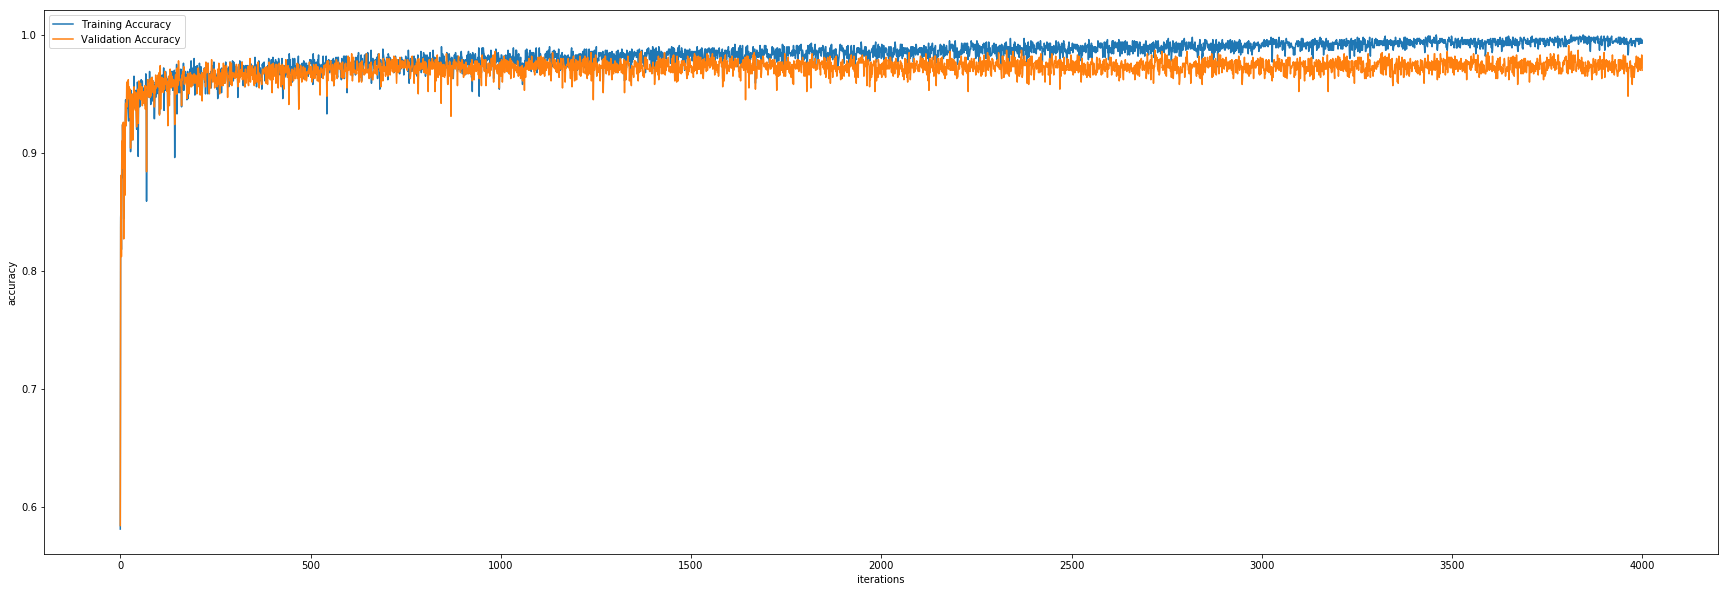

In [149]:
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(training_accuracy_list,label='Training Accuracy')
validation_accuracy_line,=plt.plot(validation_accuracy_list,label='Validation Accuracy')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

In [150]:
images_test_kaggle=np.load('data/test_images.npy')

shape_images_flat=(images_test_kaggle.shape[0],images_test_kaggle.shape[1]*images_test_kaggle.shape[2])
images_flat_k=np.ndarray(shape=shape_images_flat)

for index in range(len(images_flat_k)):
    images_flat_k[index]=images_test_kaggle[index].flat
images_flat_k=(images_flat_k-images_flat_k.min())/(images_flat_k.max()-images_flat_k.min())

images_tensor_test_kaggle = torch.from_numpy(images_flat_k).double()


prediction=predict_nn(images_tensor_test_kaggle, input_weights.data,input_bias_weight.data,hidden_weights.data ,hidden_bias_weight.data)
p=torch.t(prediction)
pred_numpy=p.numpy()[0];
pred_numpy[pred_numpy!=0]=-1
pred_numpy[pred_numpy==0]=1
pred_numpy[pred_numpy==-1]=0
pred_numpy=(pred_numpy).astype(int)
np.savetxt("data/prediction_neural_4.csv", np.dstack((np.arange(0, pred_numpy.size),pred_numpy))[0],"%d,%d",header="id,label")

I am not overfitting here as there both the cross-validation and the traing accuracy follow each other quite smoothly, if i was overfitting, though my traing would shoot up but would lead to decrease in validation accuracy

Also, i have submitted the same code on kaggle and have similar accuracy there, thus confirming that no overfitting is taking place.


# Kaggle Id: Vibhu Jawa 